# Demo

The following demo consists of two parts:
1. User can input a premise and hypothesis and the prediction is displayed for the classifier models incorporating the following four encoders:
    - BoW Baseline
    - UniLSTM
    - BiLSTM
    - BiLSTM-MaxPool
2. A list of sentences can be provided. The best-performing BiLSTM-MaxPool encoder is used to obtain their sentence embeddings. Next, a visualization of pairwise cosine similarity of the sentence embeddings is displayed.

## Loading the models

In [7]:
# Import libraries
import torch
import torchtext
from SNLIClassifier import SNLIClassifier
from nltk import word_tokenize
import json
import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

In [8]:
# Function to numericalize a sentence
def numericalize(sentence, text_vocab, device):
    sentence = word_tokenize(sentence)
    sentence_len = torch.LongTensor(1).to(device)
    sentence_len[0] = len(sentence)
    numerical_sent = [text_vocab[word] if word in text_vocab else 0 for word in sentence]
    numerical_sent = torch.tensor(numerical_sent).view(-1, 1).to(device)
    return numerical_sent, sentence_len

In [9]:
# Loading the model files and the vocab
device = torch.device('cpu')
model_path = 'checkpoint/'
checkpoint_baseline = torch.load(model_path + 'average.pt', map_location=device)
checkpoint_unilstm = torch.load(model_path + 'UniLSTM.pt', map_location=device)
checkpoint_bilstm = torch.load(model_path + 'BiLSTM.pt', map_location=device)
checkpoint_bilstm_max = torch.load(model_path + 'BiLSTMMaxPool.pt', map_location=device)
text_vocab = checkpoint_baseline['text_vocab']
label_vocab = checkpoint_baseline['label_vocab']
vocab_size = len(text_vocab)
label_mapping = sorted(label_vocab, key=label_vocab.get)

In [10]:
# Defining the models and loading the state_dict
baseline_model = SNLIClassifier(encoder='average',
                           vocab_size=vocab_size,
                           embedding_dim=300,
                           hidden_dim=2048,
                           fc_dim=512,
                           num_classes=3,
                           pretrained_vectors=None)
unilstm_model = SNLIClassifier(encoder='uniLSTM',
                           vocab_size=vocab_size,
                           embedding_dim=300,
                           hidden_dim=2048,
                           fc_dim=512,
                           num_classes=3,
                           pretrained_vectors=None)
bilstm_model = SNLIClassifier(encoder='biLSTM',
                           vocab_size=vocab_size,
                           embedding_dim=300,
                           hidden_dim=2048,
                           fc_dim=512,
                           num_classes=3,
                           pretrained_vectors=None)
bilstm_max_model = SNLIClassifier(encoder='biLSTMmaxpool',
                           vocab_size=vocab_size,
                           embedding_dim=300,
                           hidden_dim=2048,
                           fc_dim=512,
                           num_classes=3,
                           pretrained_vectors=None)

baseline_model.load_state_dict(checkpoint_baseline['model_state_dict'])
unilstm_model.load_state_dict(checkpoint_unilstm['model_state_dict'])
bilstm_model.load_state_dict(checkpoint_bilstm['model_state_dict'])
bilstm_max_model.load_state_dict(checkpoint_bilstm_max['model_state_dict'])

## Part 1 - Inference on user-input premise and hypothesis

In [117]:
# Premise input
premise = input("Enter premise: ")

Enter premise: The car was stuck in a traffic jam


In [118]:
# Hypothesis input
hypothesis = input("Enter hypothesis: ")

Enter hypothesis: The car was not stuck in a traffic jam


In [119]:
# Numericalize premise and hypothesis
premise, premise_len = numericalize(premise, text_vocab, device)
hypothesis, hypothesis_len = numericalize(hypothesis, text_vocab, device)

In [120]:
# Prediction from baseline model
baseline_model.eval()
with torch.no_grad():
    out = baseline_model(premise, hypothesis, premise_len, hypothesis_len)
    prediction = torch.argmax(out, dim=1)
print("Baseline model prediction: ", label_mapping[prediction])    

Baseline model prediction:  entailment


In [121]:
# Prediction from UniLSTM model
unilstm_model.eval()
with torch.no_grad():
    out = unilstm_model(premise, hypothesis, premise_len, hypothesis_len)
    prediction = torch.argmax(out, dim=1)
print("UniLSTM model prediction: ", label_mapping[prediction])    

UniLSTM model prediction:  contradiction


In [122]:
# Prediction from BiLSTM model
bilstm_model.eval()
with torch.no_grad():
    out = bilstm_model(premise, hypothesis, premise_len, hypothesis_len)
    prediction = torch.argmax(out, dim=1)
print("BiLSTM model prediction: ", label_mapping[prediction])

BiLSTM model prediction:  contradiction


In [123]:
# Prediction from BiLSTM-MaxPool model
bilstm_max_model.eval()
with torch.no_grad():
    out = bilstm_max_model(premise, hypothesis, premise_len, hypothesis_len)
    prediction = torch.argmax(out, dim=1)
print("BiLSTM-MaxPool model prediction: ", label_mapping[prediction])

BiLSTM-MaxPool model prediction:  entailment


## Part 2 - Similarity of sentence embeddings

In [127]:
# List of input sentences
sentence_list = ['It is raining today, hence I took an umbrella to work', 
                 'I had to take an umbrella because it was raining',
                'Amsterdam attracts a large number of visitors',
                'Amsterdam is visited by a large number of tourists',
                'I like watching Game of Thrones',
                'I dislike watching Game of Thrones',
                'Artificial intelligence is the new electricity']

In [128]:
# Obtain sentence embeddings
bilstm_max_model.eval()
sentence_embeddings = np.zeros((len(sentence_list), 2 * bilstm_max_model.hidden_dim))

with torch.no_grad():
    for idx, sentence in enumerate(sentence_list):
        sent, sent_len = numericalize(sentence, text_vocab, device)
        word_embedding = bilstm_max_model.embedding(sent)
        sent_embedding = bilstm_max_model.encoder(word_embedding, sent_len)
        sentence_embeddings[idx] = sent_embedding.numpy()  


Pairwise sentence-similarity: 


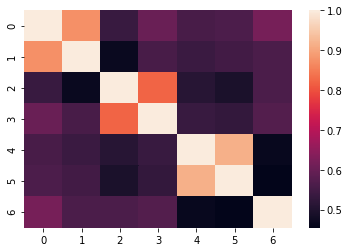

In [129]:
# Compute pairwise cosine distances and display as a heatmap
cos_dist = cosine_similarity(sentence_embeddings, sentence_embeddings)
print("Pairwise sentence cosine similarity: ")
sns.heatmap(cos_dist);